# Videos

In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pprint import pprint
from datetime import datetime
from datetime import timedelta

%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 16)

## Data preperation

In [35]:
df = pd.read_csv('../0_data/DEvideos.csv',
    low_memory=False)

df['trending_date'] = df.apply(lambda row: datetime.strptime(row['trending_date'], '%y.%d.%m'), axis=1)
df['publish_time'] = df.apply(lambda row: datetime.strptime(row['publish_time'], '%Y-%m-%dT%H:%M:%S.000Z'), axis=1)
df['days_until_trending'] = df.apply(lambda row: ((row['trending_date'] - row['publish_time']).days + 1), axis=1)

df['tags_count'] = df.apply(lambda row: len(row['tags'].split('|')), axis=1)
df['publish_hour'] = df['publish_time'].map(lambda x: x.hour)
df['publish_month'] = df['publish_time'].map(lambda x: x.month)
df['publish_year'] = df['publish_time'].map(lambda x: x.year)
df['publish_day_of_month'] = df['publish_time'].map(lambda x: x.day)
df['publish_weekday'] = df['publish_time'].map(lambda x: x.weekday()) # 0: Monday, 6: Sunday
df['trending_weekday'] = df['trending_date'].map(lambda x: x.weekday()) # 0: Monday, 6: Sunday

df['like_dislike_ratio'] = df.apply(lambda row: row['likes'] / (row['dislikes'] + 1), axis=1)
df['like_view_ratio'] = df.apply(lambda row: row['likes'] / (row['views'] + 1), axis=1)

df['ratings'] = df['likes'] + df['dislikes']
df['likes_per_rating'] = df['likes'] / df['ratings']
df['ratings_per_view'] = df['ratings'] / df['views']
df['comments_per_view'] = df['comment_count'] / df['views']

def assign_target_category(row):
    if row['days_until_trending'] == 0: 
        return '0 Days'
    elif row['days_until_trending'] == 1:
        return '1 Day'
    elif row['days_until_trending'] == 2:
        return '2 Days'
    elif row['days_until_trending'] <= 5:
        return '3 - 5 Days'
    else:
        return '> 5 Days'

df['target_category'] = df.apply(assign_target_category, axis=1)

N = len(df)
dropColumns = ['video_id', 'title', 'tags', 'thumbnail_link', 'description']
for column in df.columns:
    numberOfUniqueValues = df[column].nunique()
    if numberOfUniqueValues < 2:
        dropColumns.append(column)
    elif df[column].dtype == 'object' and numberOfUniqueValues > N * 0.9:
        dropColumns.append(column)
    elif df[column].isna().sum() / N > 0.95:
        dropColumns.append(column)
        
df.drop(columns=dropColumns, inplace=True)
df['channel_title'] = df['channel_title'].astype('category')
df['target_category'] = df['target_category'].astype('category')

### Data preview

In [36]:
df.head(10)

,trending_date,channel_title,category_id,publish_time,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,...,publish_day_of_month,publish_weekday,trending_weekday,like_dislike_ratio,like_view_ratio,ratings,likes_per_rating,ratings_per_view,comments_per_view,target_category
0,2017-11-14,inscope21,24,2017-11-13 17:08:49,252786,35885,230,1539,False,False,...,13,0,1,155.346320,0.141957,36115,0.993631,0.142868,0.006088,1 Day
1,2017-11-14,LUKE! Die Woche und ich,23,2017-11-12 22:30:01,797196,53576,302,1278,False,False,...,12,6,1,176.818482,0.067205,53878,0.994395,0.067584,0.001603,2 Days
2,2017-11-14,LastWeekTonight,24,2017-11-13 07:30:00,2418783,97190,6146,12703,False,False,...,13,0,1,15.810965,0.040181,103336,0.940524,0.042722,0.005252,1 Day
3,2017-11-14,100SekundenPhysik,27,2017-11-12 15:00:01,380247,31821,458,1955,False,False,...,12,6,1,69.326797,0.083685,32279,0.985811,0.084890,0.005141,2 Days
4,2017-11-14,rezo,24,2017-11-12 13:10:36,822213,100684,2467,10244,False,False,...,12,6,1,40.795786,0.122455,103151,0.976084,0.125455,0.012459,2 Days
5,2017-11-14,Die Allestester,22,2017-11-13 01:49:24,32709,3093,296,63,False,False,...,13,0,1,10.414141,0.094558,3389,0.912659,0.103611,0.001926,1 Day
6,2017-11-14,Bodyformus,23,2017-11-13 11:59:04,308683,35704,578,1398,False,False,...,13,0,1,61.664940,0.115665,36282,0.984069,0.117538,0.004529,1 Day
7,2017-11-14,Jay & Arya,22,2017-11-13 18:09:55,181660,17998,169,554,False,False,...,13,0,1,105.870588,0.099075,18167,0.990697,0.100006,0.003050,1 Day
8,2017-11-14,TeddyComedy,23,2017-11-12 11:53:45,369173,16953,570,611,False,False,...,12,6,1,29.690018,0.045921,17523,0.967471,0.047466,0.001655,2 Days
9,2017-11-14,WALULIS,1,2017-11-13 15:06:12,62418,4749,44,425,False,False,...,13,0,1,105.533333,0.076083,4793,0.990820,0.076789,0.006809,1 Day


## Derive categories
### Days until trending
#### Preview

In [37]:
df['days_until_trending'].describe()

count    40840.000000
mean         1.850416
std         19.621604
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max       2046.000000
Name: days_until_trending, dtype: float64

#### Distribution all

<AxesSubplot:xlabel='days_until_trending', ylabel='count'>

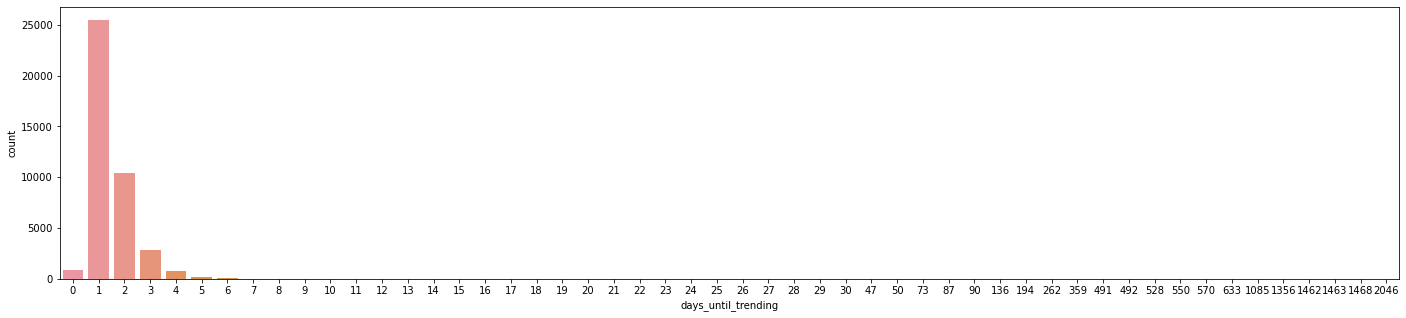

In [38]:
plt.rcParams['figure.figsize'] = (24, 5)
sns.countplot(data=df, x='days_until_trending')

#### Distribution all within the days with at least 0.1% of all videos

<AxesSubplot:xlabel='days_until_trending', ylabel='count'>

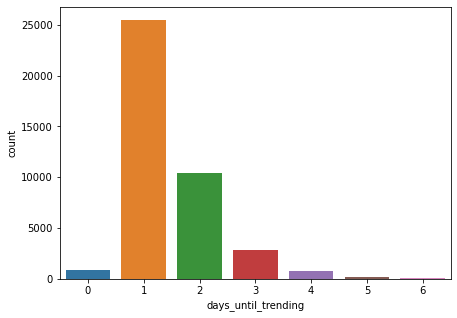

In [39]:
plt.rcParams['figure.figsize'] = (7, 5)
df2 = df.groupby('days_until_trending').filter(lambda x: len(x) >= len(df.index) / 1000)
sns.countplot(data=df2, x='days_until_trending')

### Attribute with derived categories
#### Preview

In [40]:
df['target_category'].describe()

count     40840
unique        5
top       1 Day
freq      25474
Name: target_category, dtype: object

#### Distribution

<AxesSubplot:xlabel='target_category', ylabel='count'>

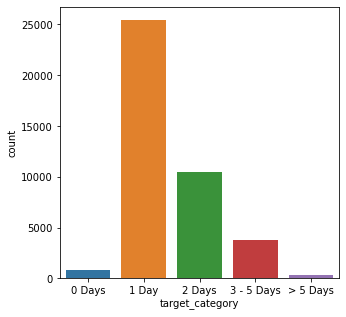

In [41]:
plt.rcParams['figure.figsize'] = (5, 5)
sns.countplot(data=df, x='target_category')

## Correlation analysis target category with channel
### Distribution channels
*df2 = Only channels with at least 0.2% of all videos in dataset*

<AxesSubplot:xlabel='count', ylabel='channel_title'>

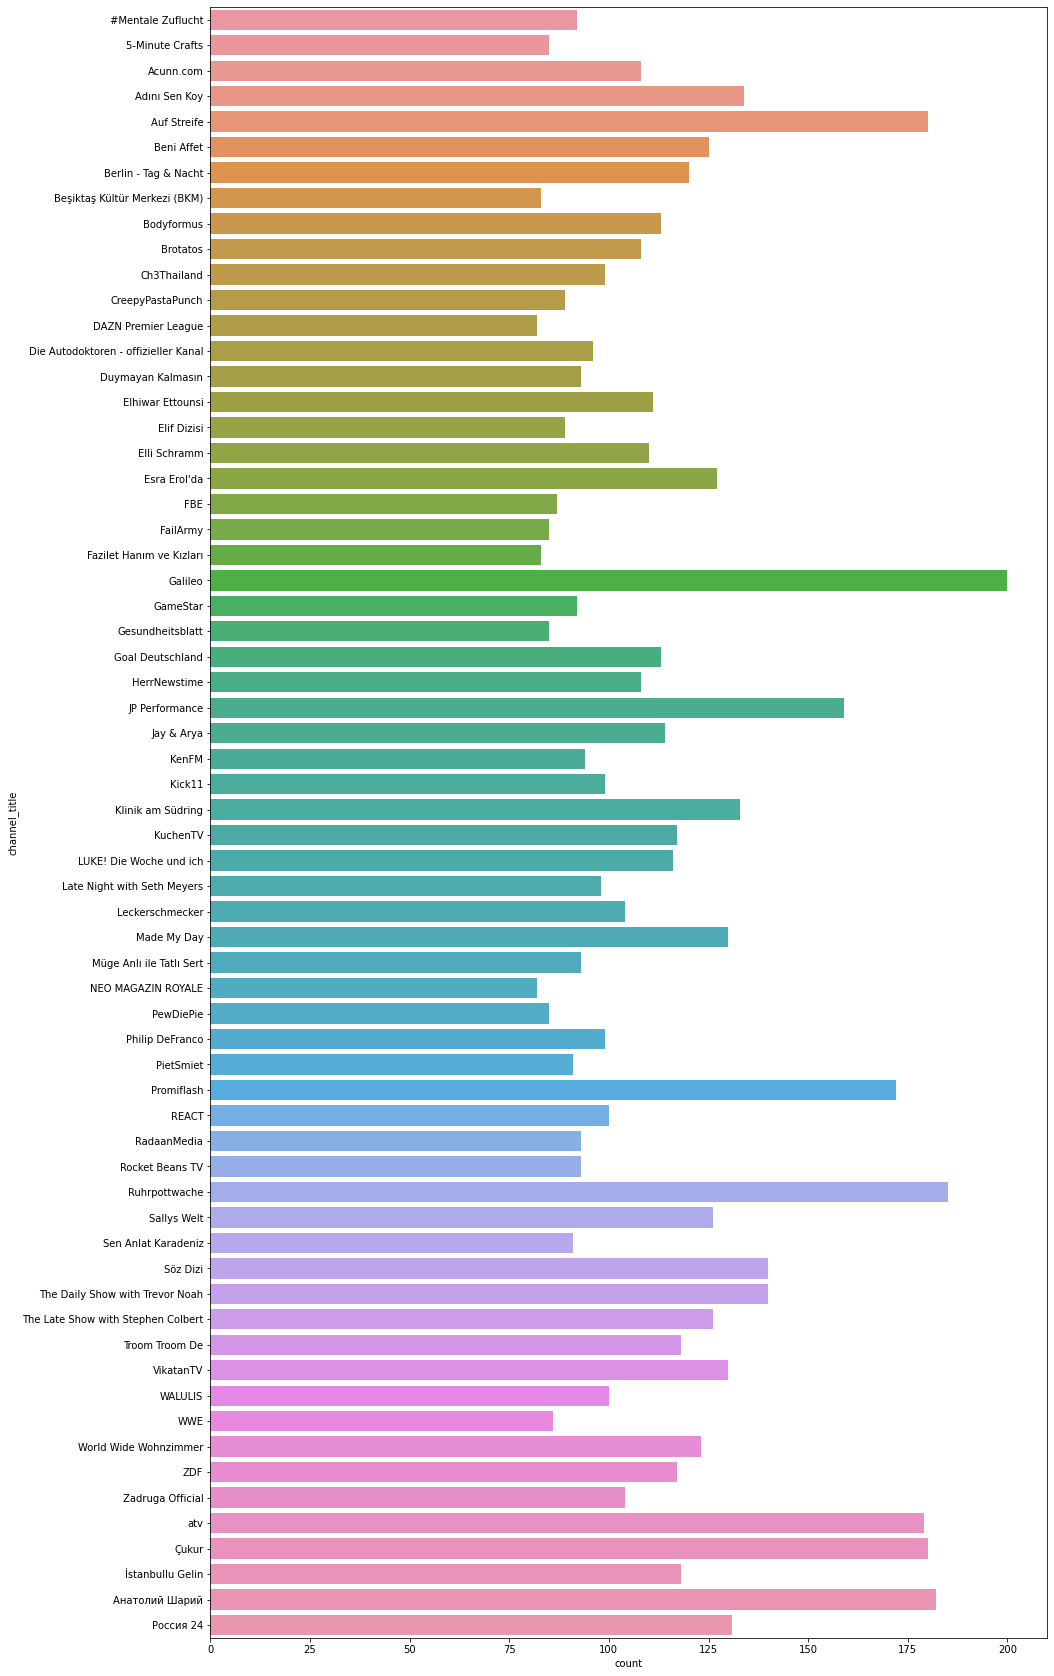

In [42]:
plt.rcParams['figure.figsize'] = (15, 30)
df2 = df.groupby('channel_title').filter(lambda x: len(x) >= len(df.index) / 500)
df2.channel_title = df2.channel_title.cat.remove_unused_categories()
sns.countplot(data=df2, y='channel_title', orient='h')

### Distribution category within channels in comparison

<AxesSubplot:xlabel='count', ylabel='channel_title'>

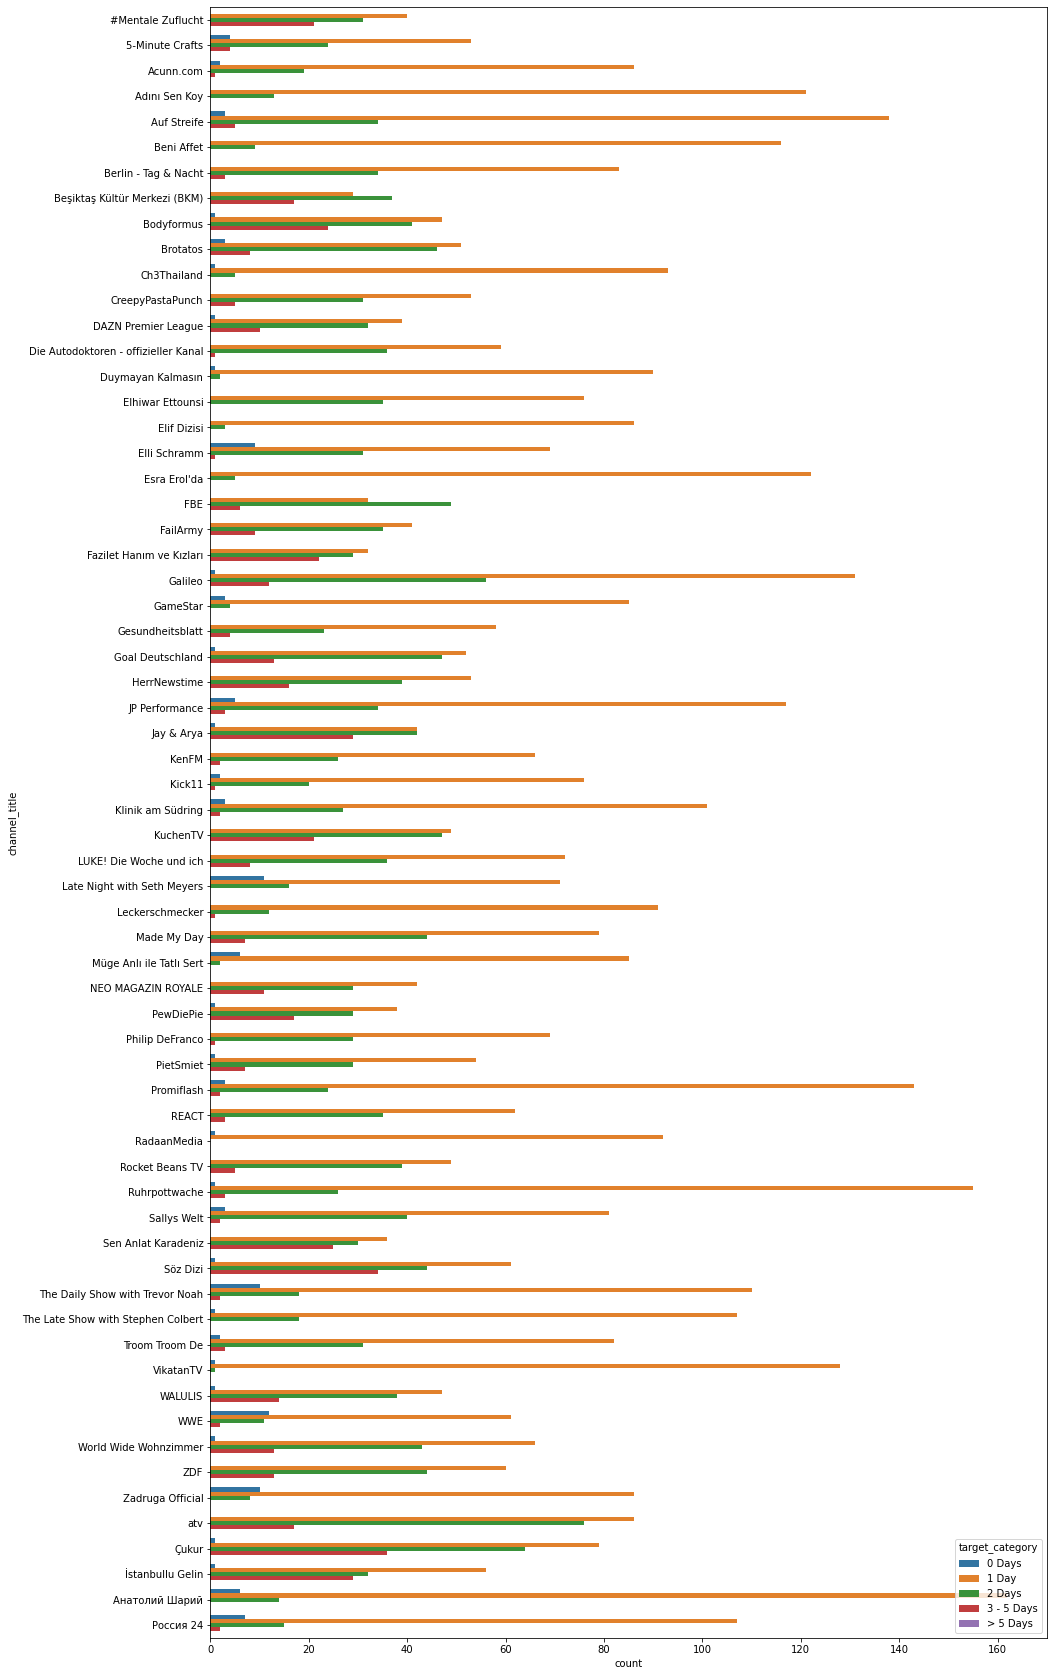

In [43]:
plt.rcParams['figure.figsize'] = (15, 30)
sns.countplot(data=df2, y='channel_title', hue='target_category')

### Distribution categories within channels and distribution channels

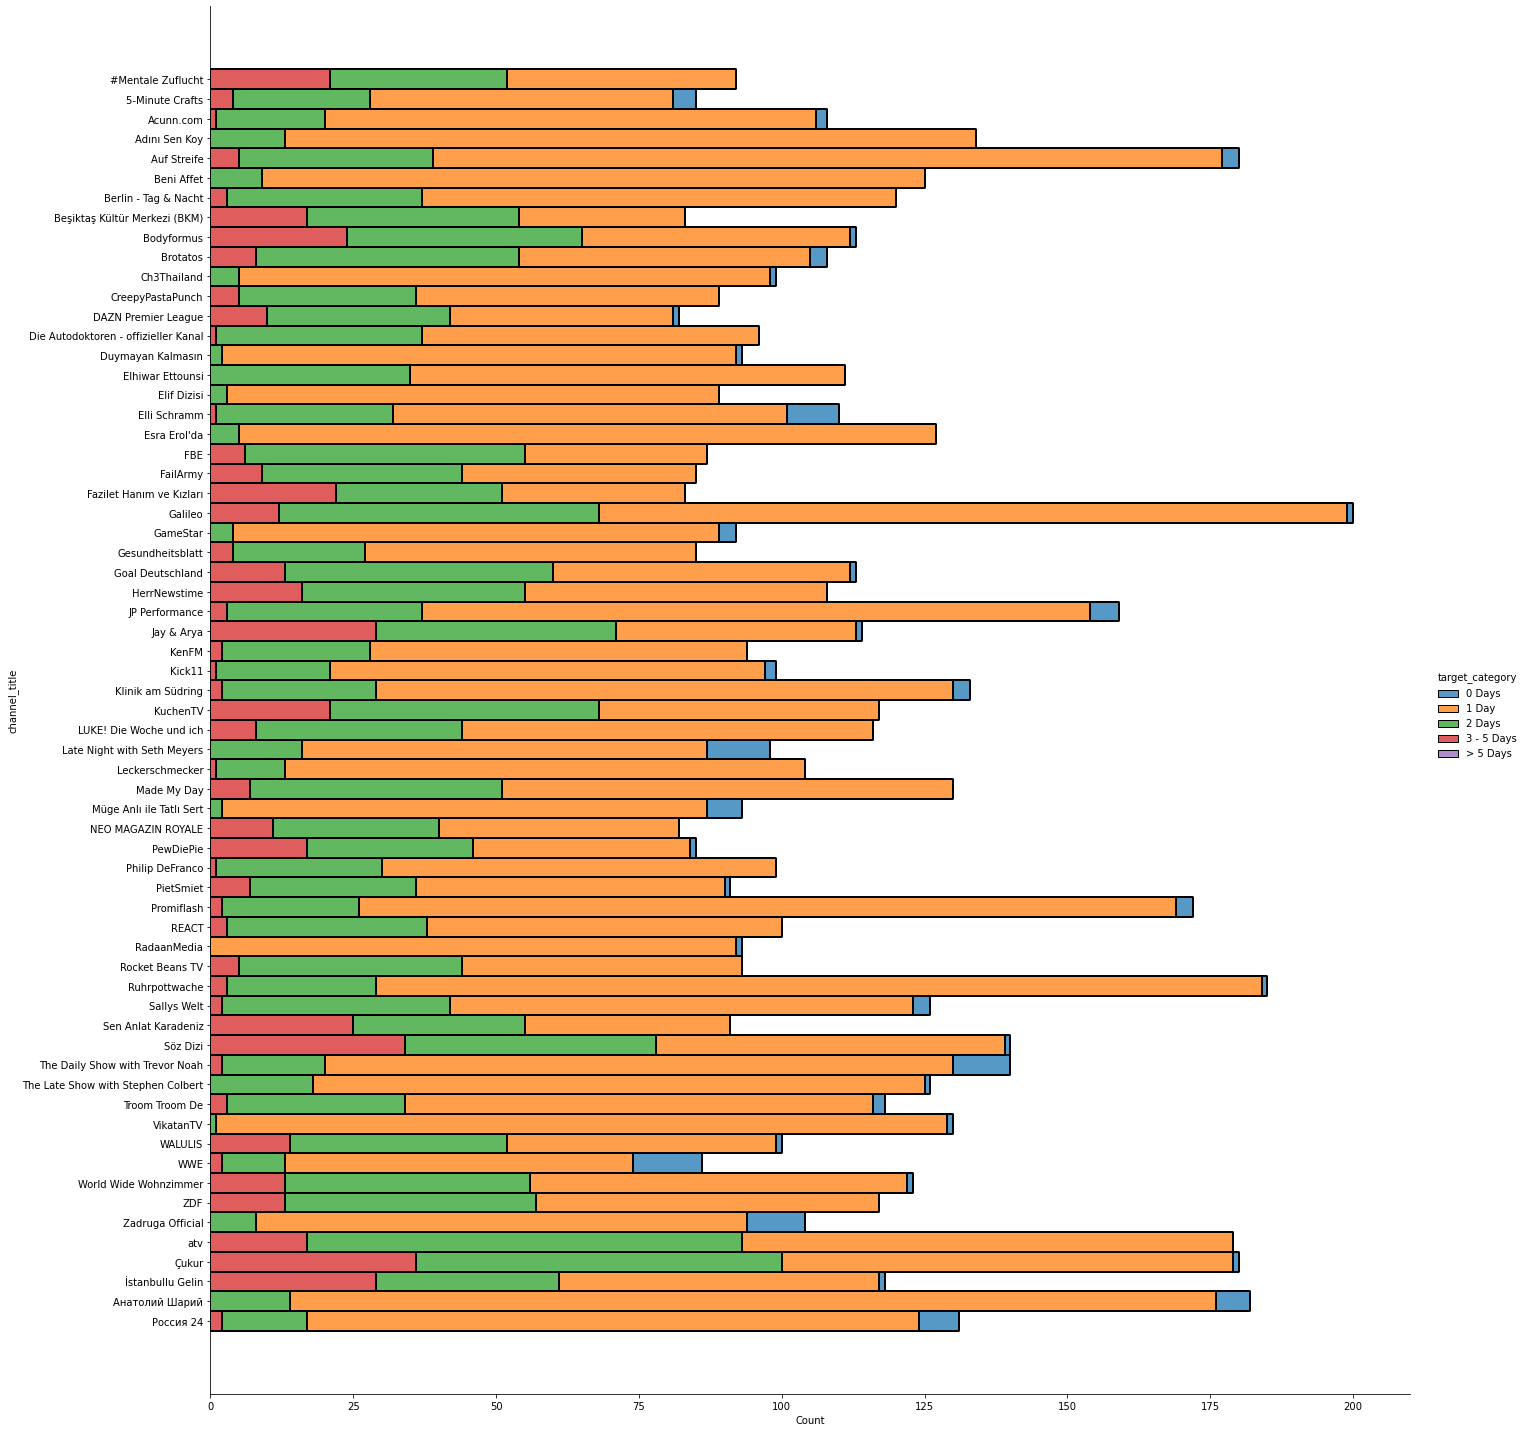

In [44]:
sns.displot(data=df2, y='channel_title', hue='target_category', multiple='stack', height=20)

### Distribution categories within channels per channel

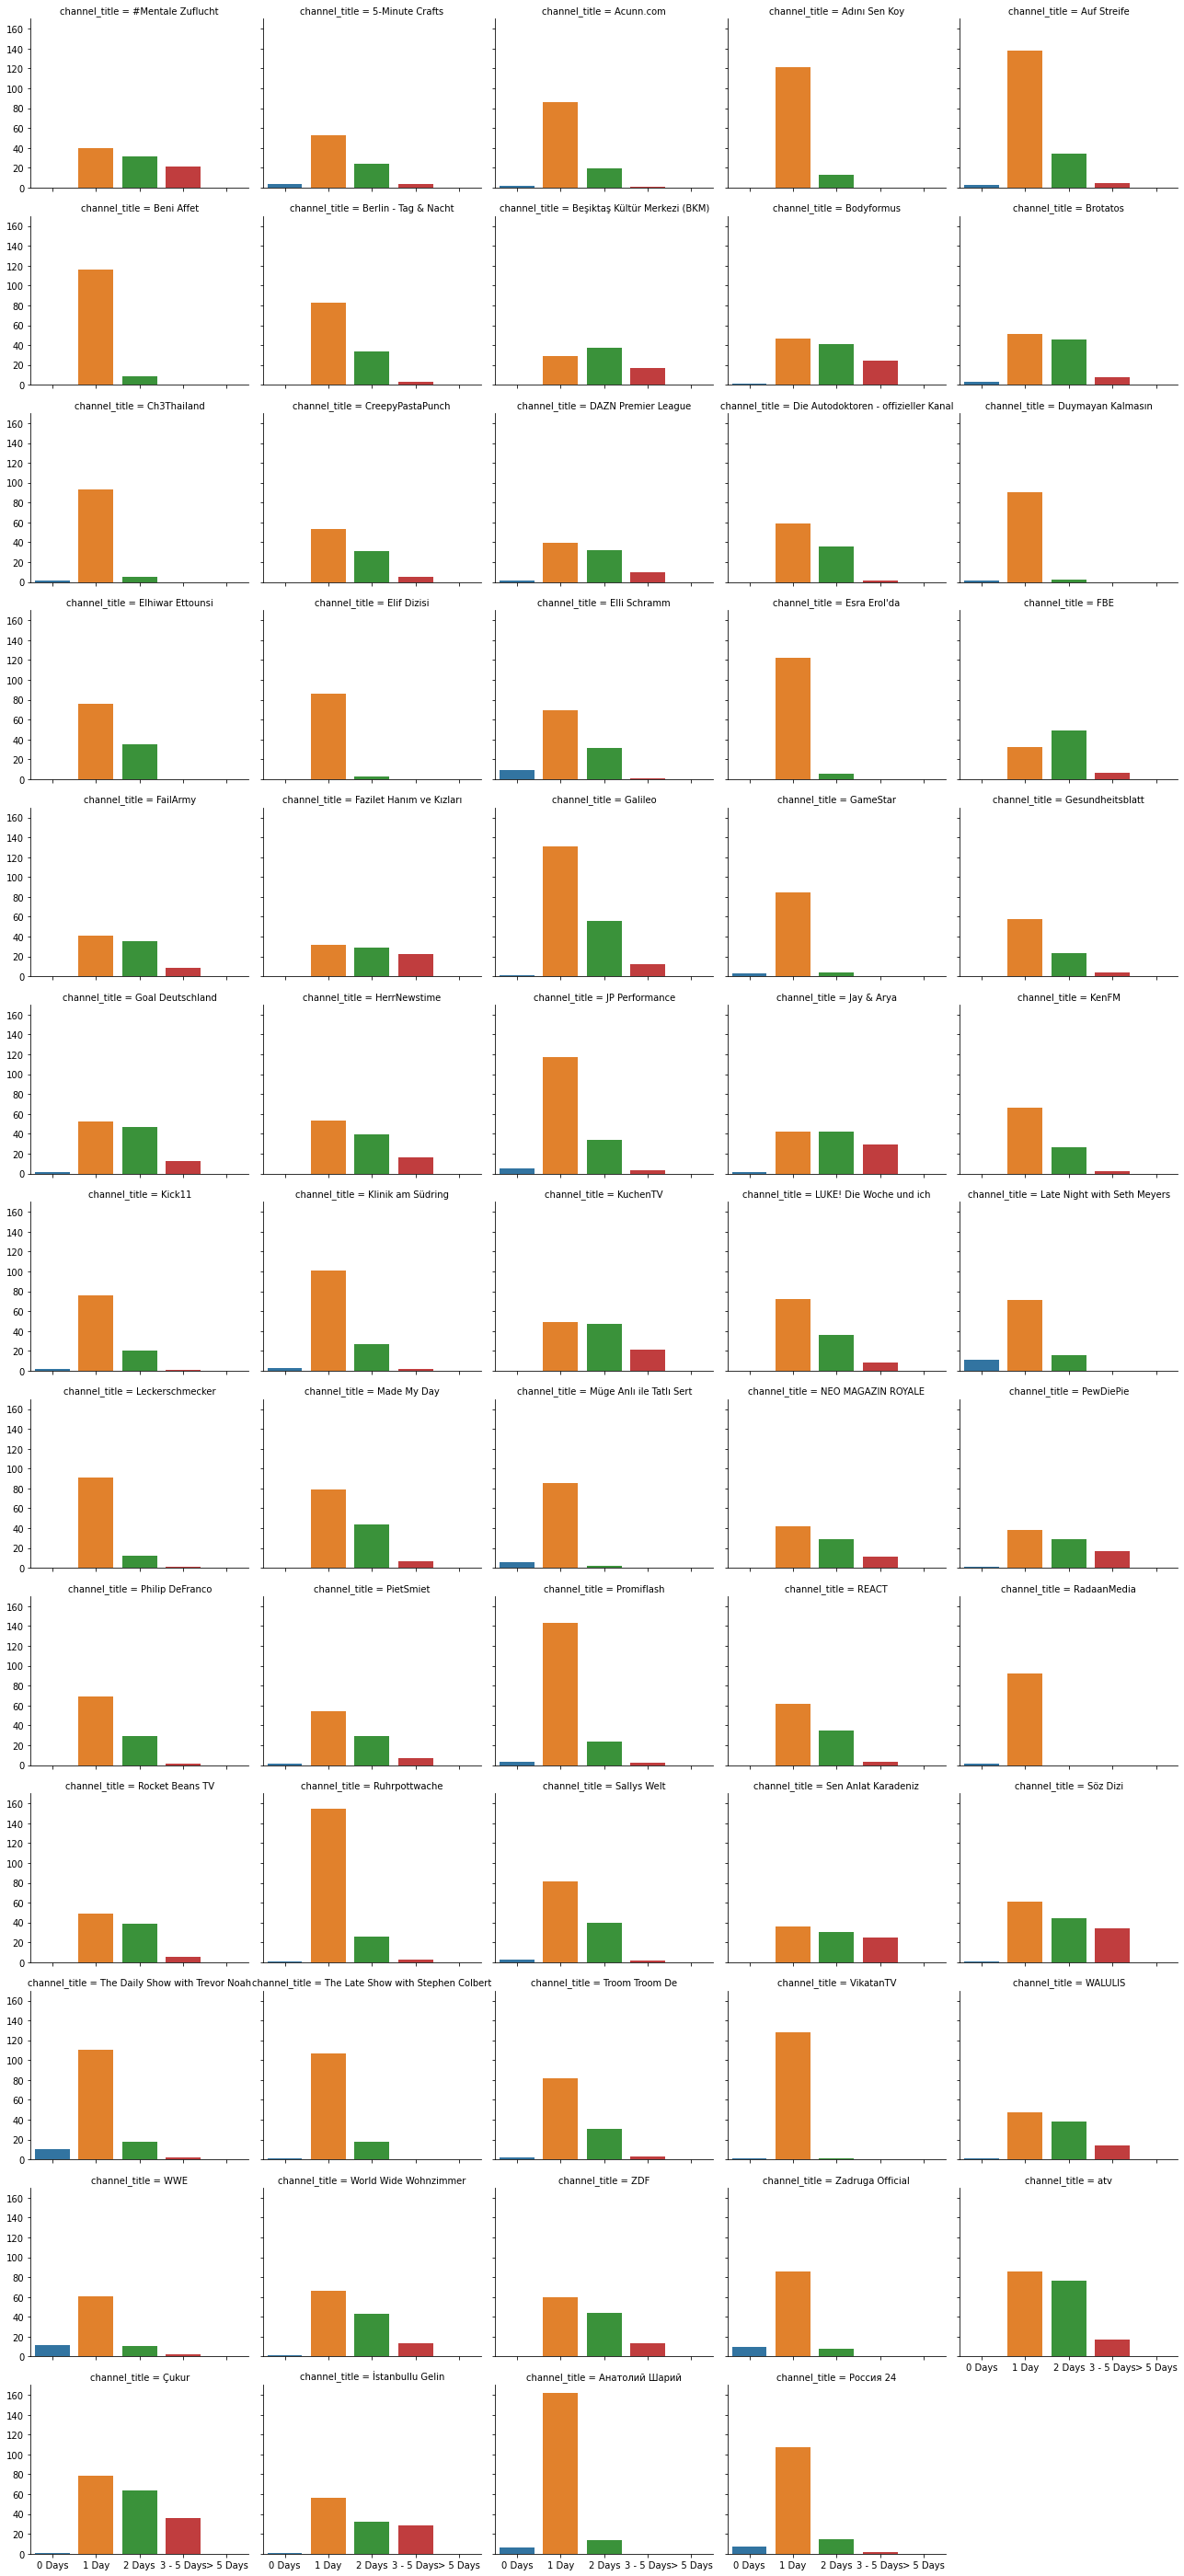

In [45]:
graph = sns.FacetGrid(data=df2, col='channel_title', col_wrap=5, height=3, aspect=1.2)
graph.map_dataframe(sns.countplot, x='target_category', palette=sns.color_palette())